# LLMCompiler

This notebook shows how to implement [LLMCompiler, by Kim, et. al](https://arxiv.org/abs/2312.04511) in LangGraph.

LLMCompiler is an agent architecture designed to **speed up** the execution of agentic tasks by eagerly-executed tasks within a DAG. It also saves costs on redundant token usage by reducing the number of calls to the LLM. Below is an overview of its computational graph:

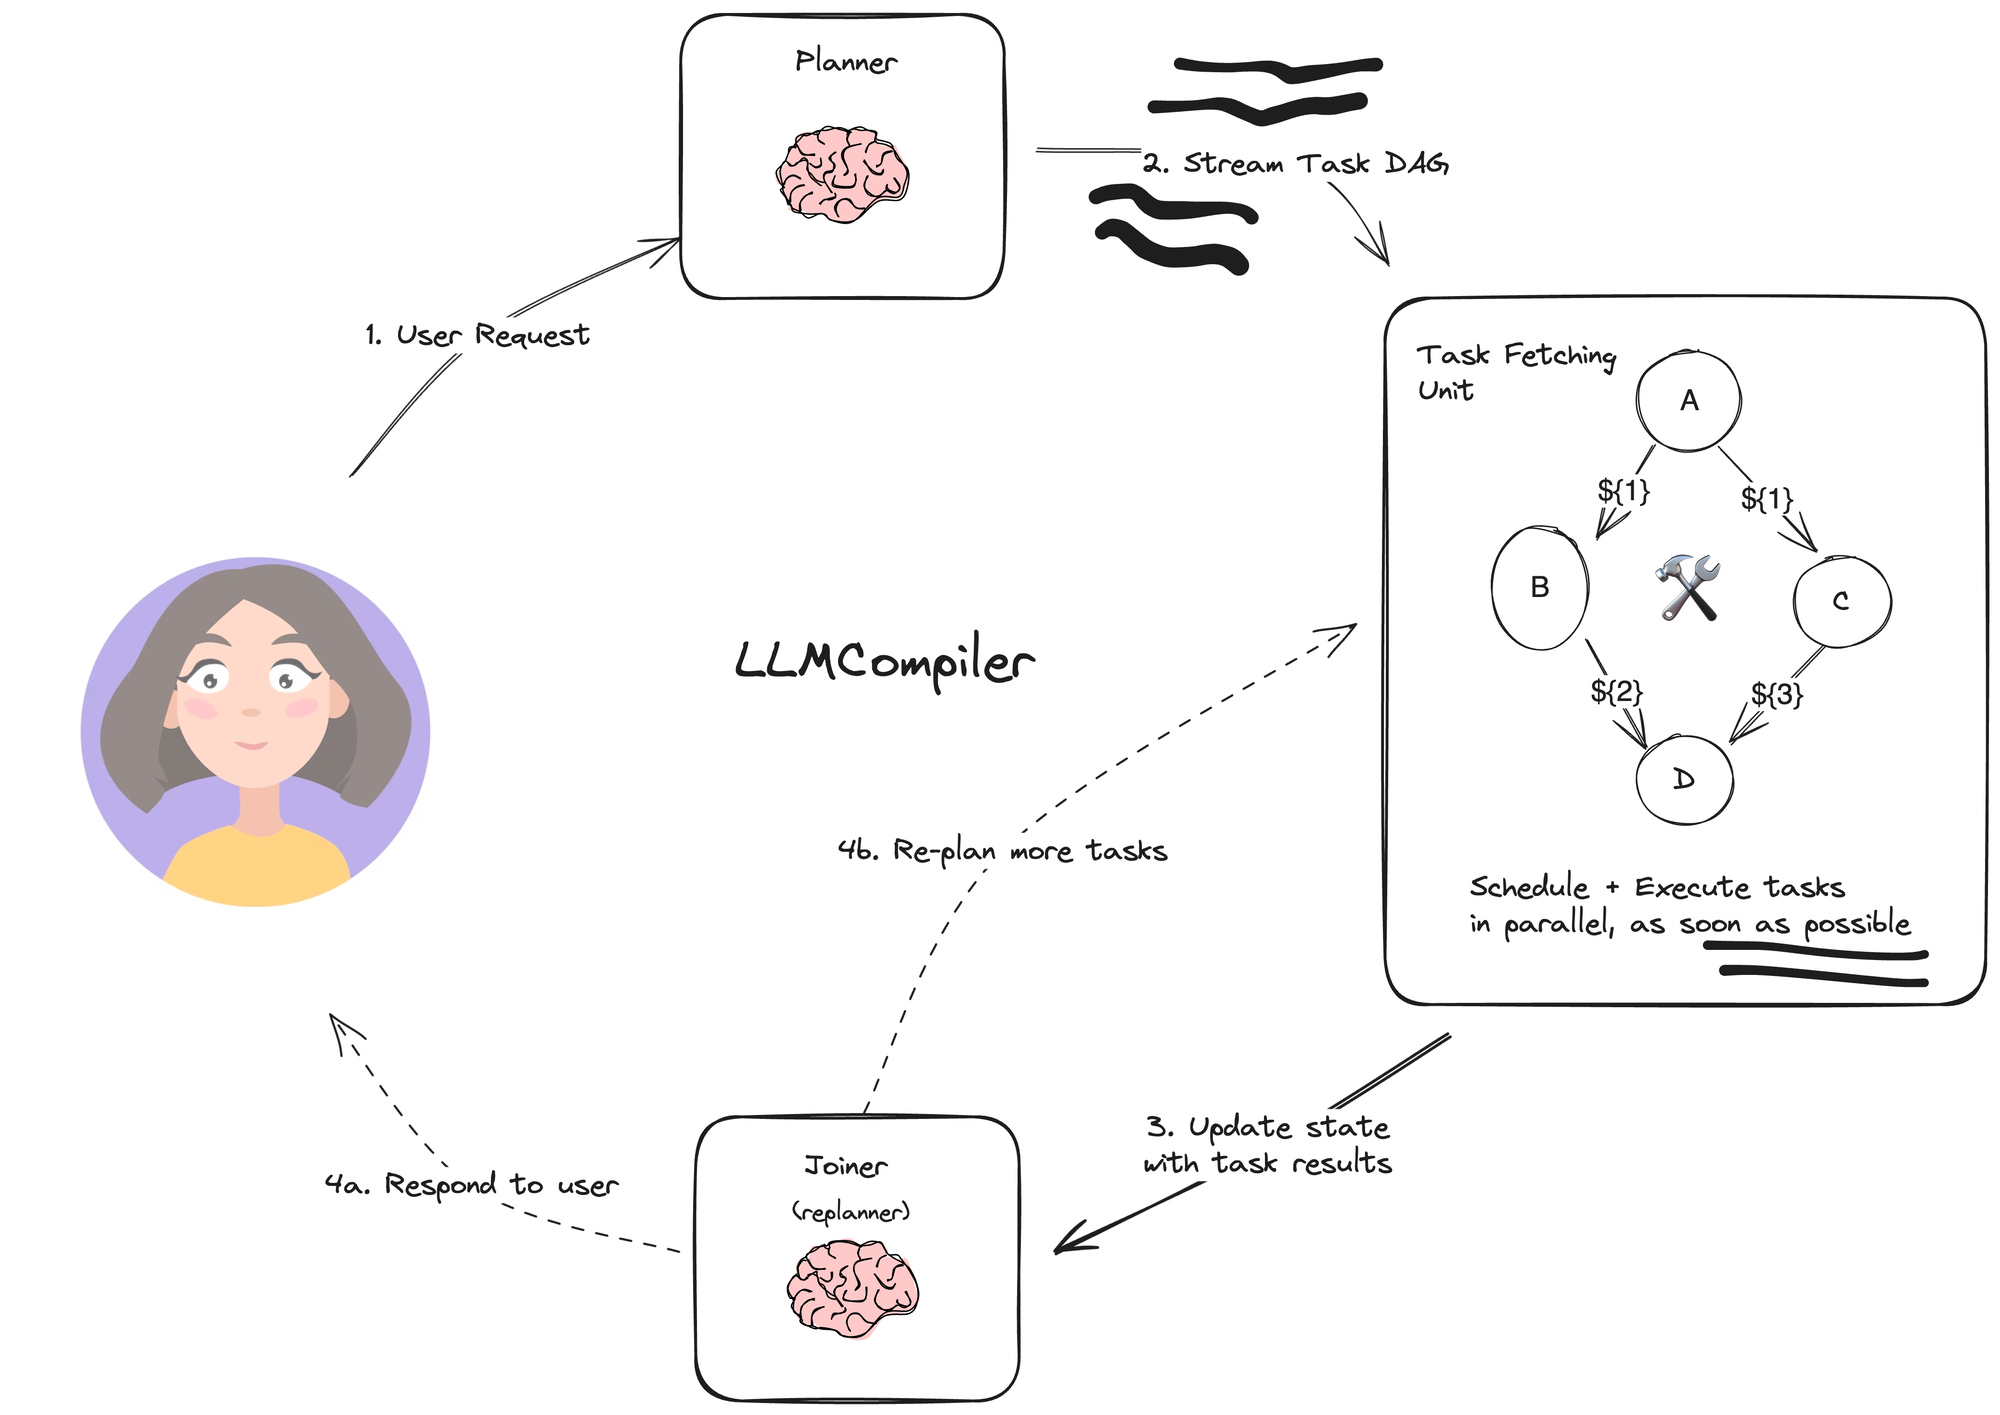

It has 3 main components:

1. Planner: stream a DAG of tasks.
2. Task Fetching Unit: schedules and executes the tasks as soon as they are executable
3. Joiner: Responds to the user or triggers a second plan


This notebook walks through each component and shows how to wire them together using LangGraph. The end result will leave a trace [like the following](https://smith.langchain.com/public/218c2677-c719-4147-b0e9-7bc3b5bb2623/r).


## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain_openai langsmith langgraph langchain numexpr

In [2]:
import getpass
import os


def _get_pass(var: str):
    if var not in os.environ:
        os.environ[var] = getpass.getpass(f"{var}: ")


_get_pass("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Helper Files

### Math Tools

Place the following code in a file called `math_tools.py` and ensure that you can import it into this notebook.

<div>
  <button type="button" style="border: 1px solid black; border-radius: 5px; padding: 5px; background-color: lightgrey;" onclick="toggleVisibility('helper-functions')">Show/Hide Math Tools</button>
  <div id="helper-functions" style="display:none;">
    <!-- Helper functions -->
    <pre>

    import math
    import re
    from typing import List, Optional

    import numexpr
    from langchain.chains.openai_functions import create_structured_output_runnable
    from langchain_core.messages import SystemMessage
    from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
    from langchain_core.runnables import RunnableConfig
    from langchain_core.tools import StructuredTool
    from langchain_openai import ChatOpenAI
    from pydantic import BaseModel, Field

    _MATH_DESCRIPTION = (
        "math(problem: str, context: Optional[list[str]]) -> float:\n"
        " - Solves the provided math problem.\n"
        ' - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n'
        " - You cannot calculate multiple expressions in one call. For instance, `math('1 + 3, 2 + 4')` does not work. "
        "If you need to calculate multiple expressions, you need to call them separately like `math('1 + 3')` and then `math('2 + 4')`\n"
        " - Minimize the number of `math` actions as much as possible. For instance, instead of calling "
        '2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), '
        'you MUST call 2. math("what is the 110% of $1") instead, which will reduce the number of math actions.\n'
        # Context specific rules below
        " - You can optionally provide a list of strings as `context` to help the agent solve the problem. "
        "If there are multiple contexts you need to answer the question, you can provide them as a list of strings.\n"
        " - `math` action will not see the output of the previous actions unless you provide it as `context`. "
        "You MUST provide the output of the previous actions as `context` if you need to do math on it.\n"
        " - You MUST NEVER provide `search` type action's outputs as a variable in the `problem` argument. "
        "This is because `search` returns a text blob that contains the information about the entity, not a number or value. "
        "Therefore, when you need to provide an output of `search` action, you MUST provide it as a `context` argument to `math` action. "
        'For example, 1. search("Barack Obama") and then 2. math("age of $1") is NEVER allowed. '
        'Use 2. math("age of Barack Obama", context=["$1"]) instead.\n'
        " - When you ask a question about `context`, specify the units. "
        'For instance, "what is xx in height?" or "what is xx in millions?" instead of "what is xx?"\n'
    )


    _SYSTEM_PROMPT = """Translate a math problem into a expression that can be executed using Python's numexpr library. Use the output of running this code to answer the question.

    Question: ${{Question with math problem.}}
    ```text
    ${{single line mathematical expression that solves the problem}}
    ```
    ...numexpr.evaluate(text)...
    ```output
    ${{Output of running the code}}
    ```
    Answer: ${{Answer}}

    Begin.

    Question: What is 37593 * 67?
    ExecuteCode({{code: "37593 * 67"}})
    ...numexpr.evaluate("37593 * 67")...
    ```output
    2518731
    ```
    Answer: 2518731

    Question: 37593^(1/5)
    ExecuteCode({{code: "37593**(1/5)"}})
    ...numexpr.evaluate("37593**(1/5)")...
    ```output
    8.222831614237718
    ```
    Answer: 8.222831614237718
    """

    _ADDITIONAL_CONTEXT_PROMPT = """The following additional context is provided from other functions.\
        Use it to substitute into any ${{#}} variables or other words in the problem.\
        \n\n${context}\n\nNote that context variables are not defined in code yet.\
    You must extract the relevant numbers and directly put them in code."""


    class ExecuteCode(BaseModel):
        """The input to the numexpr.evaluate() function."""

        reasoning: str = Field(
            ...,
            description="The reasoning behind the code expression, including how context is included, if applicable.",
        )

        code: str = Field(
            ...,
            description="The simple code expression to execute by numexpr.evaluate().",
        )


    def _evaluate_expression(expression: str) -> str:
        try:
            local_dict = {"pi": math.pi, "e": math.e}
            output = str(
                numexpr.evaluate(
                    expression.strip(),
                    global_dict={},  # restrict access to globals
                    local_dict=local_dict,  # add common mathematical functions
                )
            )
        except Exception as e:
            raise ValueError(
                f'Failed to evaluate "{expression}". Raised error: {repr(e)}.'
                " Please try again with a valid numerical expression"
            )

        # Remove any leading and trailing brackets from the output
        return re.sub(r"^\[|\]$", "", output)


    def get_math_tool(llm: ChatOpenAI):
        prompt = ChatPromptTemplate.from_messages(
            [
                ("system", _SYSTEM_PROMPT),
                ("user", "{problem}"),
                MessagesPlaceholder(variable_name="context", optional=True),
            ]
        )
        extractor = prompt | llm.with_structured_output(ExecuteCode)

        def calculate_expression(
            problem: str,
            context: Optional[List[str]] = None,
            config: Optional[RunnableConfig] = None,
        ):
            chain_input = {"problem": problem}
            if context:
                context_str = "\n".join(context)
                if context_str.strip():
                    context_str = _ADDITIONAL_CONTEXT_PROMPT.format(
                        context=context_str.strip()
                    )
                    chain_input["context"] = [SystemMessage(content=context_str)]
            code_model = extractor.invoke(chain_input, config)
            try:
                return _evaluate_expression(code_model.code)
            except Exception as e:
                return repr(e)

        return StructuredTool.from_function(
            name="math",
            func=calculate_expression,
            description=_MATH_DESCRIPTION,
        )

</pre>
  </div>
</div>

<script>
  function toggleVisibility(id) {
    var element = document.getElementById(id);
    element.style.display = (element.style.display === "none") ? "block" : "none";
  }
</script>

### Output Parser

<div>
  <button type="button" style="border: 1px solid black; border-radius: 5px; padding: 5px; background-color: lightgrey;" onclick="toggleVisibility('helper-functions-2')">Show/Hide Output Parser</button>
  <div id="helper-functions-2" style="display:none;">
    <!-- Helper functions -->
    <pre>

    import ast
    import re
    from typing import (
        Any,
        Dict,
        Iterator,
        List,
        Optional,
        Sequence,
        Tuple,
        Union,
    )

    from langchain_core.exceptions import OutputParserException
    from langchain_core.messages import BaseMessage
    from langchain_core.output_parsers.transform import BaseTransformOutputParser
    from langchain_core.runnables import RunnableConfig
    from langchain_core.tools import BaseTool
    from typing_extensions import TypedDict

    THOUGHT_PATTERN = r"Thought: ([^\n]*)"
    ACTION_PATTERN = r"\n*(\d+)\. (\w+)\((.*)\)(\s*#\w+\n)?"
    # $1 or ${1} -> 1
    ID_PATTERN = r"\$\{?(\d+)\}?"
    END_OF_PLAN = "<END_OF_PLAN>"


    ### Helper functions


    def _ast_parse(arg: str) -> Any:
        try:
            return ast.literal_eval(arg)
        except:  # noqa
            return arg


    def _parse_llm_compiler_action_args(args: str, tool: Union[str, BaseTool]) -> list[Any]:
        """Parse arguments from a string."""
        if args == "":
            return ()
        if isinstance(tool, str):
            return ()
        extracted_args = {}
        tool_key = None
        prev_idx = None
        for key in tool.args.keys():
            # Split if present
            if f"{key}=" in args:
                idx = args.index(f"{key}=")
                if prev_idx is not None:
                    extracted_args[tool_key] = _ast_parse(
                        args[prev_idx:idx].strip().rstrip(",")
                    )
                args = args.split(f"{key}=", 1)[1]
                tool_key = key
                prev_idx = 0
        if prev_idx is not None:
            extracted_args[tool_key] = _ast_parse(
                args[prev_idx:].strip().rstrip(",").rstrip(")")
            )
        return extracted_args


    def default_dependency_rule(idx, args: str):
        matches = re.findall(ID_PATTERN, args)
        numbers = [int(match) for match in matches]
        return idx in numbers


    def _get_dependencies_from_graph(
        idx: int, tool_name: str, args: Dict[str, Any]
    ) -> dict[str, list[str]]:
        """Get dependencies from a graph."""
        if tool_name == "join":
            return list(range(1, idx))
        return [i for i in range(1, idx) if default_dependency_rule(i, str(args))]


    class Task(TypedDict):
        idx: int
        tool: BaseTool
        args: list
        dependencies: Dict[str, list]
        thought: Optional[str]


    def instantiate_task(
        tools: Sequence[BaseTool],
        idx: int,
        tool_name: str,
        args: Union[str, Any],
        thought: Optional[str] = None,
    ) -> Task:
        if tool_name == "join":
            tool = "join"
        else:
            try:
                tool = tools[[tool.name for tool in tools].index(tool_name)]
            except ValueError as e:
                raise OutputParserException(f"Tool {tool_name} not found.") from e
        tool_args = _parse_llm_compiler_action_args(args, tool)
        dependencies = _get_dependencies_from_graph(idx, tool_name, tool_args)

        return Task(
            idx=idx,
            tool=tool,
            args=tool_args,
            dependencies=dependencies,
            thought=thought,
        )


    class LLMCompilerPlanParser(BaseTransformOutputParser[dict], extra="allow"):
        """Planning output parser."""

        tools: List[BaseTool]

        def _transform(self, input: Iterator[Union[str, BaseMessage]]) -> Iterator[Task]:
            texts = []
            # TODO: Cleanup tuple state tracking here.
            thought = None
            for chunk in input:
                # Assume input is str. TODO: support vision/other formats
                text = chunk if isinstance(chunk, str) else str(chunk.content)
                for task, thought in self.ingest_token(text, texts, thought):
                    yield task
            # Final possible task
            if texts:
                task, _ = self._parse_task("".join(texts), thought)
                if task:
                    yield task

        def parse(self, text: str) -> List[Task]:
            return list(self._transform([text]))

        def stream(
            self,
            input: str | BaseMessage,
            config: RunnableConfig | None = None,
            **kwargs: Any | None,
        ) -> Iterator[Task]:
            yield from self.transform([input], config, **kwargs)

        def ingest_token(
            self, token: str, buffer: List[str], thought: Optional[str]
        ) -> Iterator[Tuple[Optional[Task], str]]:
            buffer.append(token)
            if "\n" in token:
                buffer_ = "".join(buffer).split("\n")
                suffix = buffer_[-1]
                for line in buffer_[:-1]:
                    task, thought = self._parse_task(line, thought)
                    if task:
                        yield task, thought
                buffer.clear()
                buffer.append(suffix)

        def _parse_task(self, line: str, thought: Optional[str] = None):
            task = None
            if match := re.match(THOUGHT_PATTERN, line):
                # Optionally, action can be preceded by a thought
                thought = match.group(1)
            elif match := re.match(ACTION_PATTERN, line):
                # if action is parsed, return the task, and clear the buffer
                idx, tool_name, args, _ = match.groups()
                idx = int(idx)
                task = instantiate_task(
                    tools=self.tools,
                    idx=idx,
                    tool_name=tool_name,
                    args=args,
                    thought=thought,
                )
                thought = None
            # Else it is just dropped
            return task, thought


</pre>
  </div>
</div>

<script>
  function toggleVisibility(id) {
    var element = document.getElementById(id);
    element.style.display = (element.style.display === "none") ? "block" : "none";
  }
</script>

## Define Tools

We'll first define the tools for the agent to use in our demo. We'll give it the class search engine + calculator combo.

If you don't want to sign up for tavily, you can replace it with the free [DuckDuckGo](https://python.langchain.com/docs/integrations/tools/ddg/).

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from math_tools import get_math_tool

_get_pass("TAVILY_API_KEY")

calculate = get_math_tool(ChatOpenAI(model="gpt-4-turbo-preview"))
search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)

tools = [search, calculate]

In [7]:
calculate.invoke(
    {
        "problem": "What's the temp of sf + 5?",
        "context": ["Thet empreature of sf is 32 degrees"],
    }
)

'37'

## Planner


Largely adapted from [the original source code](https://github.com/SqueezeAILab/LLMCompiler/blob/main/src/llm_compiler/output_parser.py), the planner  accepts the input question and generates a task list to execute.

If it is provided with a previous plan, it is instructed to re-plan, which is useful if, upon completion of the first batch of tasks, the agent must take more actions.

The code below composes constructs the prompt template for the planner and composes it with LLM and output parser, defined in `output_parser.py`. The output parser processes a task list in the following form:

```plaintext
1. tool_1(arg1="arg1", arg2=3.5, ...)
Thought: I then want to find out Y by using tool_2
2. tool_2(arg1="", arg2="${1}")'
3. join()<END_OF_PLAN>"
```

The "Thought" lines are optional. The `${#}` placeholders are variables. These are used to route tool (task) outputs to other tools.

In [10]:
from typing import Sequence

from langchain import hub
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
from output_parser import LLMCompilerPlanParser, Task

prompt = hub.pull("wfh/llm-compiler")
print(prompt.pretty_print())

================================ System Message ================================

Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
{tool_descriptions}
{num_tools}. join(): Collects and combines results from prior actions.

 - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
 - join should always be the last action in the plan, and will be called in two scenarios:
   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
   (b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
 - Each action described above contains input/output types and description.
    - You must strictly adhere to the input and output types for each action.
    - The action descriptions contain the guidelines. You MUST strictly follow those guideline

In [11]:
def create_planner(
    llm: BaseChatModel, tools: Sequence[BaseTool], base_prompt: ChatPromptTemplate
):
    tool_descriptions = "\n".join(
        f"{i+1}. {tool.description}\n"
        for i, tool in enumerate(
            tools
        )  # +1 to offset the 0 starting index, we want it count normally from 1.
    )
    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools)
        + 1,  # Add one because we're adding the join() tool at the end.
        tool_descriptions=tool_descriptions,
    )
    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools) + 1,
        tool_descriptions=tool_descriptions,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        return {"messages": state}

    def wrap_and_get_last_index(state: list):
        next_task = 0
        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs["idx"] + 1
                break
        state[-1].content = state[-1].content + f" - Begin counting at : {next_task}"
        return {"messages": state}

    return (
        RunnableBranch(
            (should_replan, wrap_and_get_last_index | replanner_prompt),
            wrap_messages | planner_prompt,
        )
        | llm
        | LLMCompilerPlanParser(tools=tools)
    )

In [12]:
llm = ChatOpenAI(model="gpt-4-turbo-preview")
# This is the primary "agent" in our application
planner = create_planner(llm, tools, prompt)

In [13]:
example_question = "What's the temperature in SF raised to the 3rd power?"

for task in planner.stream([HumanMessage(content=example_question)]):
    print(task["tool"], task["args"])
    print("---")

description='tavily_search_results_json(query="the search query") - a search engine.' max_results=1 api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')) {'query': 'current temperature in San Francisco'}
---
name='math' description='math(problem: str, context: Optional[list[str]]) -> float:\n - Solves the provided math problem.\n - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n - You cannot calculate multiple expressions in one call. For instance, `math(\'1 + 3, 2 + 4\')` does not work. If you need to calculate multiple expressions, you need to call them separately like `math(\'1 + 3\')` and then `math(\'2 + 4\')`\n - Minimize the number of `math` actions as much as possible. For instance, instead of calling 2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), you MUST call 2. math("what is the 110% of $1") instead, which will reduce the number of 

## Task Fetching Unit

This component schedules the tasks. It receives a stream of tools of the following format:

```typescript
{
    tool: BaseTool,
    dependencies: number[],
}
```


The basic idea is to begin executing tools as soon as their dependencies are met. This is done through multi-threading. We will combine the task fetching unit and executor below:

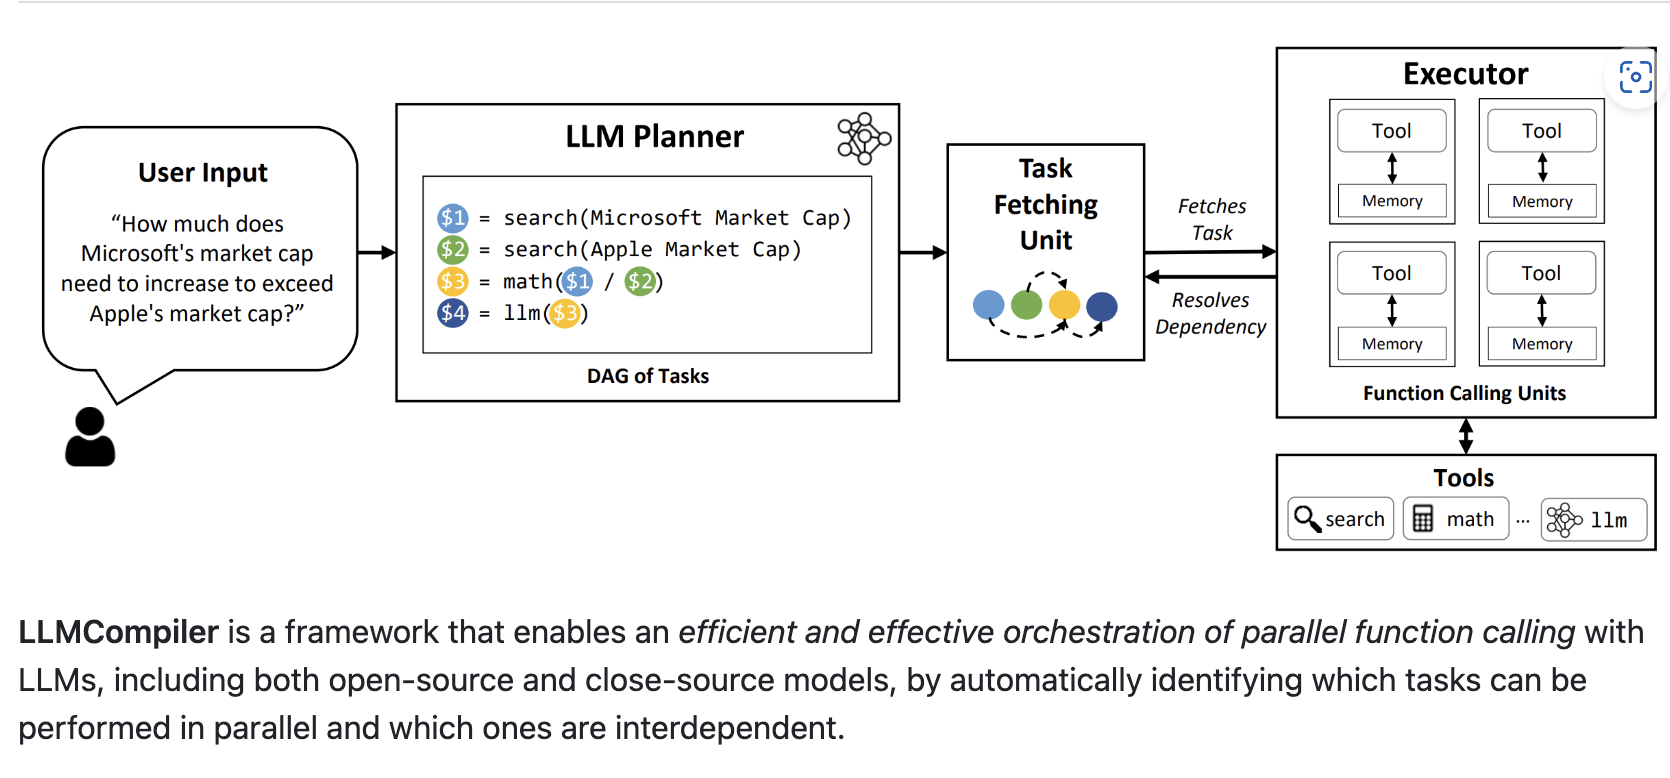

In [14]:
import re
import time
from concurrent.futures import ThreadPoolExecutor, wait
from typing import Any, Dict, Iterable, List, Union

from langchain_core.runnables import (
    chain as as_runnable,
)
from typing_extensions import TypedDict


def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs["idx"])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task["tool"]
    if isinstance(tool_to_use, str):
        return tool_to_use
    args = task["args"]
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            # This will likely fail
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )
    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )


def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    # $1 or ${1} -> 1
    ID_PATTERN = r"\$\{?(\d+)\}?"

    def replace_match(match):
        # If the string is ${123}, match.group(0) is ${123}, and match.group(1) is 123.

        # Return the match group, in this case the index, from the string. This is the index
        # number we get back.
        idx = int(match.group(1))
        return str(observations.get(idx, match.group(0)))

    # For dependencies on other tasks
    if isinstance(arg, str):
        return re.sub(ID_PATTERN, replace_match, arg)
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback

        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    args_for_tasks = {}
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            args_for_tasks[task["idx"]] = task["args"]
            if (
                # Depends on other tasks
                deps
                and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], args_for_tasks[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(
            name=name, content=str(obs), additional_kwargs={"idx": k, "args": task_args}, tool_call_id = k
        )
        for k, (name, task_args, obs) in new_observations.items()
    ]
    return tool_messages

In [15]:
import itertools


@as_runnable
def plan_and_schedule(state):
    messages = state["messages"]
    tasks = planner.stream(messages)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        }
    )
    return {"messages": scheduled_tasks}

### Example Plan

We still haven't introduced any cycles in our computation graph, so this is all easily expressed in LCEL.

In [16]:
tool_messages = plan_and_schedule.invoke({"messages":[HumanMessage(content=example_question)]})['messages']

In [17]:
tool_messages

[FunctionMessage(content="[{'url': 'https://www.accuweather.com/en/us/san-francisco/94103/current-weather/347629', 'content': 'Get the latest weather information for San Francisco, CA, including temperature, wind, humidity, pressure, and UV index. See hourly, daily, and monthly forecasts, as ...'}]", additional_kwargs={'idx': 1, 'args': {'query': 'current temperature in San Francisco'}}, response_metadata={}, name='tavily_search_results_json', tool_call_id=1),
 FunctionMessage(content='ValueError(\'Failed to evaluate "No specific value for \\\'x\\\' provided.". Raised error: SyntaxError(\\\'invalid syntax\\\', (\\\'<expr>\\\', 1, 4, "No specific value for \\\'x\\\' provided.", 1, 12)). Please try again with a valid numerical expression\')', additional_kwargs={'idx': 2, 'args': {'problem': 'x^3', 'context': ['$1']}}, response_metadata={}, name='math', tool_call_id=2),
 FunctionMessage(content='join', additional_kwargs={'idx': 3, 'args': ()}, response_metadata={}, name='join', tool_call_

## Joiner

So now we have the planning and initial execution done. We need a component to process these outputs and either:

1. Respond with the correct answer.
2. Loop with a new plan.

The paper refers to this as the "joiner". It's another LLM call. We are using function calling to improve parsing reliability.

In [18]:
from langchain_core.messages import AIMessage
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel, Field


class FinalResponse(BaseModel):
    """The final response/answer."""

    response: str


class Replan(BaseModel):
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response."""

    thought: str = Field(
        description="The chain of thought reasoning for the selected action"
    )
    action: Union[FinalResponse, Replan]


joiner_prompt = hub.pull("wfh/llm-compiler-joiner").partial(
    examples=""
)  # You can optionally add examples
llm = ChatOpenAI(model="gpt-4-turbo-preview")

runnable = joiner_prompt | llm.with_structured_output(JoinOutputs)

We will select only the most recent messages in the state, and format the output to be more useful for
the planner, should the agent need to loop.

In [19]:
def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return {"messages": response + [
            SystemMessage(
                content=f"Context from last attempt: {decision.action.feedback}"
            )
        ]
        }
    else:
        return {"messages": response + [AIMessage(content=decision.action.response)]}


def select_recent_messages(state) -> dict:
    messages = state["messages"]
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break
    return {"messages": selected[::-1]}


joiner = select_recent_messages | runnable | _parse_joiner_output

In [20]:
input_messages = [HumanMessage(content=example_question)] + tool_messages

In [21]:
joiner.invoke({"messages":input_messages})

{'messages': [AIMessage(content='Thought: Since the temperature in San Francisco was not provided, I cannot calculate its value raised to the 3rd power. The search result did not include specific temperature information, and the subsequent action to calculate the power raised the error due to lack of numerical input.', additional_kwargs={}, response_metadata={}),
  SystemMessage(content="Context from last attempt: To answer the user's question, we need the current temperature in San Francisco. Please include a step to find the current temperature in San Francisco and then calculate its value raised to the 3rd power.", additional_kwargs={}, response_metadata={})]}

## Compose using LangGraph

We'll define the agent as a stateful graph, with the main nodes being:

1. Plan and execute (the DAG from the first step above)
2. Join: determine if we should finish or replan
3. Recontextualize: update the graph state based on the output from the joiner

In [22]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
    "join",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
graph_builder.add_edge(START, "plan_and_schedule")
chain = graph_builder.compile()

### Simple question

Let's ask a simple question of the agent.

In [23]:
for step in chain.stream(
    {"messages": [HumanMessage(content="What's the GDP of New York?")]}
):
    print(step)
    print("---")

{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://www.investopedia.com/articles/investing/011516/new-yorks-economy-6-industries-driving-gdp-growth.asp', 'content': 'The manufacturing sector is a leader in railroad rolling stock, as many of the earliest railroads were financed or founded in New York; garments, as New York City is the fashion capital of the U.S.; elevator parts; glass; and many other products.\\n Educational Services\\nThough not typically thought of as a leading industry, the educational sector in New York nonetheless has a substantial impact on the state and its residents, and in attracting new talent that eventually enters the New York business scene. New York has seen a large uptick in college attendees, both young and old, over the 21st century, and an increasing number of new employees in other New York sectors were educated in the state. New York City is the leading job hub for banking, finance, and communication in the U.S. New York i

In [24]:
# Final answer
print(step['join']['messages'][-1].content)

The GDP of New York is $1.7 trillion.


### Multi-hop question

This question requires that the agent perform multiple searches.

In [25]:
steps = chain.stream({"messages":
    [
        HumanMessage(
            content="What's the oldest parrot alive, and how much longer is that than the average?"
        )
    ]
    },
    {
        "recursion_limit": 100,
    },
)
for step in steps:
    print(step)
    print("---")

{'plan_and_schedule': {'messages': [FunctionMessage(content='[{\'url\': \'https://en.wikipedia.org/wiki/Cookie_(cockatoo)\', \'content\': \'He was one of the longest-lived birds on record[4] and was recognised by the Guinness World Records as the oldest living parrot in the world.[5]\\nThe next-oldest pink cockatoo to be found in a zoological setting was a 31-year-old female bird located at Paradise Wildlife Sanctuary, England.[3] Information published by the World Parrot Trust states longevity for Cookie\\\'s species in captivity is on average 40–60 years.[6]\\nLife[edit]\\nCookie was Brookfield Zoo\\\'s oldest resident and the last surviving member of the animal collection from the time of the zoo\\\'s opening in 1934, having arrived from Taronga Zoo of Sydney, New South Wales, Australia, in the same year and judged to be one year old at the time.[7]\\nIn the 1950s an attempt was made to introduce Cookie to a female pink cockatoo, but Cookie rejected her as "she was not nice to him".

In [26]:
# Final answer
print(step['join']['messages'][-1].content)

Cookie the cockatoo was recognized as the oldest living parrot, reaching the age of 82, which is significantly beyond the average lifespan for his species, noted to be between 40-60 years in captivity. While general information for parrots suggests varying lifespans with some capable of living up to 60 years in captivity, Cookie's age far exceeded these averages, highlighting his exceptional longevity.


### Multi-step  math

In [27]:
for step in chain.stream({"messages":
    [
        HumanMessage(
            content="What's ((3*(4+5)/0.5)+3245) + 8? What's 32/4.23? What's the sum of those two values?"
        )
    ]}
):
    print(step)

{'plan_and_schedule': {'messages': [FunctionMessage(content='3307.0', additional_kwargs={'idx': 1, 'args': {'problem': '((3*(4+5)/0.5)+3245) + 8'}}, response_metadata={}, name='math', tool_call_id=1), FunctionMessage(content='7.565011820330969', additional_kwargs={'idx': 2, 'args': {'problem': '32/4.23'}}, response_metadata={}, name='math', tool_call_id=2), FunctionMessage(content='join', additional_kwargs={'idx': 3, 'args': ()}, response_metadata={}, name='join', tool_call_id=3)]}}
{'join': {'messages': [AIMessage(content="Thought: The calculations for both the expressions provided by the user have been successfully completed, with the results being 3307.0 for the first expression and 7.565011820330969 for the second. Therefore, we have all the necessary information to answer the user's question.", additional_kwargs={}, response_metadata={}, id='2dd394b3-468a-4abc-b7d2-02f7b803a8b6'), AIMessage(content='The result of the first calculation ((3*(4+5)/0.5)+3245) + 8 is 3307.0, and the re

In [28]:
# Final answer
print(step['join']['messages'][-1].content)

The result of the first calculation ((3*(4+5)/0.5)+3245) + 8 is 3307.0, and the result of the second calculation (32/4.23) is approximately 7.57. The sum of those two values is 3307.0 + 7.57 = approximately 3314.57.


### Complex Replanning Example

This question is likely to prompt the Replan functionality, but it may need to be run multiple times to see this in action.

In [29]:
for step in chain.stream({"messages":
    [
        HumanMessage(
            content="Find the current temperature in Tokyo, then, respond with a flashcard summarizing this information"
        )
    ]}
):
    print(step)

{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://www.timeanddate.com/weather/japan/tokyo/ext', 'content': 'Tokyo 14 Day Extended Forecast. Weather Today Weather Hourly 14 Day Forecast Yesterday/Past Weather Climate (Averages) Currently: 84 °F. Partly sunny. (Weather station: Tokyo, Japan). See more current weather.'}]", additional_kwargs={'idx': 1, 'args': {'query': 'current temperature in Tokyo'}}, response_metadata={}, name='tavily_search_results_json', tool_call_id=1), FunctionMessage(content='join', additional_kwargs={'idx': 2, 'args': ()}, response_metadata={}, name='join', tool_call_id=2)]}}
{'join': {'messages': [AIMessage(content='Thought: The extracted information provides the current temperature in Tokyo, which is 84 °F and describes the weather as partly sunny. This information is sufficient to create a flashcard summary for the user.', additional_kwargs={}, response_metadata={}, id='e9a1af40-ca06-4eb8-b4bb-24429cf8c689'), AIMessage(content='**F

## Conclusion

Congrats on building your first LLMCompiler agent! I'll leave you with some known limitations to the implementation above:

1. The planner output parsing format is fragile if your function requires more than 1 or 2 arguments. We could make it more robust by using streaming tool calling.
2. Variable substitution is fragile in the example above. It could be made more robust by using a fine-tuned model and a more robust syntax (using e.g., Lark or a tool calling schema)
3. The state can grow quite long if you require multiple re-planning runs. To handle, you could add a message compressor once you go above a certain token limit.
